[09-06-2025 13:45:40] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_normal_df.pkl]
[09-06-2025 13:45:40] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_ddos_df.pkl]
[09-06-2025 13:45:40] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_dos_df.pkl]
[09-06-2025 13:45:40] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_injection_df.pkl]
[09-06-2025 13:45:40] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_backdoor_df.pkl]
[09-06-2025 13:45:40] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_runsomware_df.pkl]
[09-06-2025 13:45:40] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_mitm_df.pkl]
/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-v

best params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 1000}
accurracy: 0.9888888888888889


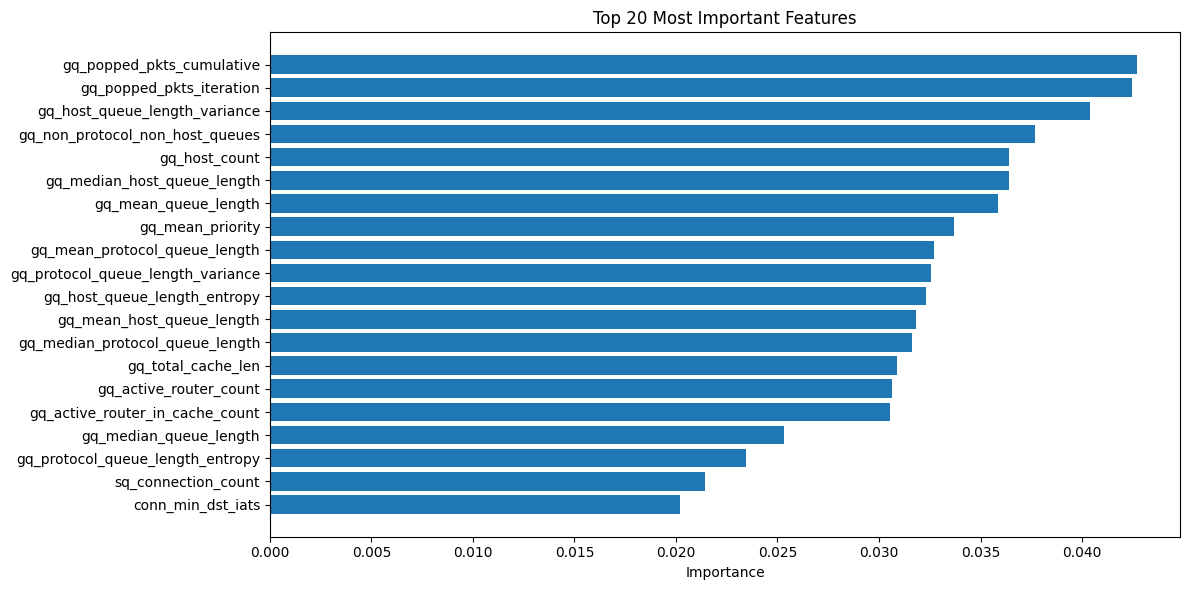

In [ ]:
import data_analysis.data_processing as dp
import data_analysis.data_learning as dl

# reload module to bypass caching
import importlib
importlib.reload(dp)
importlib.reload(dl)

# paths
test_window_path_home = dp.Path(r'\\?\C:\Users\jannis\Documents\HSP_IDS\Material\Aktuell\2025-02-17_11-14-33_192.168.1.0-normal_1\1554220324.748197-1554220354.748197') # treat it as a long path to avoid path length issues on windows
test_window_path_remote = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-03-04_00-03-20_192.168.1.0-normal_DDoS_1/1556203726.876922-1556203756.876922')

data_set_path = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes')
ddos_test_path_parquet = dp.Path(r'/home/hsp252/Development/DDoS')

# get host-based fvs
fvs = dp.pd.DataFrame()
labels = dp.pd.DataFrame()

normal = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_normal_df.pkl')
labels = dp.pd.concat([labels, normal['attack_type']])
fvs = dp.pd.concat([fvs, normal])

ddos = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_ddos_df.pkl')
labels = dp.pd.concat([labels, ddos['attack_type']])
fvs = dp.pd.concat([fvs, ddos])

dos = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_dos_df.pkl')
labels = dp.pd.concat([labels, dos['attack_type']])
fvs = dp.pd.concat([fvs, dos])

injection = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_injection_df.pkl')
labels = dp.pd.concat([labels, injection['attack_type']])
fvs = dp.pd.concat([fvs, injection])

backdoor = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_backdoor_df.pkl')
labels = dp.pd.concat([labels, backdoor['attack_type']])
fvs = dp.pd.concat([fvs, backdoor])

runsomeware = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_runsomware_df.pkl')
labels = dp.pd.concat([labels, runsomeware['attack_type']])
fvs = dp.pd.concat([fvs, runsomeware])

mitm = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_mitm_df.pkl')
labels = dp.pd.concat([labels, mitm['attack_type']])
fvs = dp.pd.concat([fvs, mitm])

fvs = fvs.iloc[:, 4:].drop('attack_type', axis=1)

# create and train rfc
le = dl.LabelEncoder()
labels = le.fit_transform(labels)

x_train, x_test, y_train, y_test = dl.train_test_split(fvs, labels, stratify=labels)
rfc = dl.RandomForestClassifier()

grid = {'n_estimators':[1000],
        'max_depth':[3, 5, 7, 10, 20, 25],
        'min_samples_leaf':[1, 2]}
gs = dl.GridSearchCV(estimator=rfc, param_grid=grid, scoring='accuracy', cv=3, return_train_score=True)
gs.fit(x_train, y_train)

best_rfc = gs.best_estimator_
predictions = best_rfc.predict(x_test)

print(f"best params: {gs.best_params_}")
print(f"accurracy: {dl.accuracy_score(y_test, predictions)}")

# plot feature importances
feature_importance_df = dp.pd.DataFrame({'feature': fvs.columns, 'importance': best_rfc.feature_importances_})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

dp.plt.figure(figsize=(12, 6))
dp.plt.barh(feature_importance_df['feature'][:20][::-1], feature_importance_df['importance'][:20][::-1])
dp.plt.xlabel("Importance")
dp.plt.title("Top 20 Most Important Features")
dp.plt.tight_layout()
dp.plt.show()


# TODO: pkls laufen lassen, Klassenbalance erstmal nicht wichtig Murad Featureunterschiede schicken, parquet für Rest machen, identifizierende Features raus, Feature-Wichtigkeit evaluieren, Aufgabe: Wie gut kann man überhaupt klassifizieren? Bringt das alles was? Bei größeren Rechnern schauen, wie viel Leistung das zieht (htop)
# test_ddos_parquet = dp.pd.read_parquet('../DDoS/intrusion_normal_DDoS_10_final.parquet')
# test_ddos_parquet_cleaned = test_ddos_parquet[17:].select_dtypes(include='number')
# bool_columns = test_ddos_parquet_cleaned.select_dtypes(include='bool').columns
# test_ddos_parquet_cleaned[bool_columns] = test_ddos_parquet_cleaned[bool_columns].astype(float)


